In [31]:
import sqlite3
import pandas as pd

# Conectar a la base de datos SQLite
conn = sqlite3.connect("data_lake.bd")
cursor = conn.cursor()

# Crear la tabla raw_temperatures si no existe
cursor.execute("""
    CREATE TABLE IF NOT EXISTS raw_temperatures (
        fecha TEXT,
        tempeProm REAL,
        ciudad TEXT,
        pais TEXT
    )
""")

# Cargar los datasets
df1 = pd.read_csv("dataset1.csv")
df2 = pd.read_csv("dataset2.csv")

# Mostrar nombres de columnas de cada dataset, y asi saber qué columnas me sirven
print("Columnas en dataset 1:", df1.columns.tolist())
print("Columnas en dataset 2:", df2.columns.tolist())

# Limpiar espacios en nombres de columnas en df2
df2.columns = df2.columns.str.strip()

# Renombrar columnas para que las pueda "unir" en el data lake
df1 = df1.rename(columns={"Date": "fecha", "AverageTemperature": "tempeProm", "City": "ciudad", "Country": "pais"})
df2 = df2.rename(columns={"dt": "fecha", "AverageTemperature": "tempeProm", "City": "ciudad", "Country": "pais"})

# Mostrar nombres de columnas después de renombrar, para asi ver que las columnas "sean compatibles"
print("Columnas después de renombrar dataset 1:", df1.columns.tolist())
print("Columnas después de renombrar dataset 2:", df2.columns.tolist())

# Asegurar que solo tengan las columnas necesarias
df1 = df1[["fecha", "tempeProm", "ciudad", "pais"]]
df2 = df2[["fecha", "tempeProm", "ciudad", "pais"]]

# Unir ambos datasets (formar el data lake)
df = pd.concat([df1, df2], ignore_index=True)

# Los metemos en la tabla del data lake
df.to_sql("raw_temperatures", conn, if_exists="append", index=False)

# Cerrar la conexión
conn.close()

Columnas en dataset 1: ['"Entry ID"', 'Date', 'Year', 'AverageTemperature', 'City', 'Country']
Columnas en dataset 2: ['dt', 'AverageTemperature', 'AverageTemperatureUncertainty', 'City', 'Country', 'Latitude', 'Longitude']
Columnas después de renombrar dataset 1: ['"Entry ID"', 'fecha', 'Year', 'tempeProm', 'ciudad', 'pais']
Columnas después de renombrar dataset 2: ['fecha', 'tempeProm', 'AverageTemperatureUncertainty', 'ciudad', 'pais', 'Latitude', 'Longitude']


In [5]:
import sqlite3
import pandas as pd

# Conectar a la base de datos SQLite
conn = sqlite3.connect("data_lake.bd")

# Leer los primeros 5 registros de la tabla
df = pd.read_sql("SELECT * FROM raw_temperatures LIMIT 5;", conn)

# Mostrar el resultado
print(df)

# Cerrar la conexión
conn.close()

        fecha  tempeProm ciudad     pais
0  1743-11-01      6.068  Århus  Denmark
1  1743-12-01        NaN  Århus  Denmark
2  1744-01-01        NaN  Århus  Denmark
3  1744-02-01        NaN  Århus  Denmark
4  1744-03-01        NaN  Århus  Denmark


In [34]:
import sqlite3
import pandas as pd

# Conectar a la base de datos
conn = sqlite3.connect("data_lake.bd")

# Leer los últimos 5 registros de la tabla
df = pd.read_sql("SELECT * FROM raw_temperatures ORDER BY fecha DESC LIMIT 5;", conn)

# Mostramos el resultado
print(df)

conn.close()

      fecha tempeProm   ciudad        pais
0  9/1/2013      None    Århus     Denmark
1  9/1/2013      None    Çorlu      Turkey
2  9/1/2013      None    Çorum      Turkey
3  9/1/2013      None  Öskemen  Kazakhstan
4  9/1/2013      None   Ürümqi       China


In [7]:
import sqlite3
import pandas as pd

# Conectar a la base de datos
conn = sqlite3.connect("data_lake.bd")

# Cargar los datos en un DataFrame
df = pd.read_sql("SELECT * FROM raw_temperatures;", conn)

# Contar valores nulos por columna
print("Valores nulos por columna:")
print(df.isnull().sum())

# Cerrar conexión
conn.close()

Valores nulos por columna:
fecha            0
tempeProm    58549
ciudad           0
pais             0
dtype: int64


In [8]:
df_invalid_temp = df[(df["tempeProm"] < -100) | (df["tempeProm"] > 100)]
print("Registros con temperaturas inconsistentes:")
print(df_invalid_temp)

Registros con temperaturas inconsistentes:
Empty DataFrame
Columns: [fecha, tempeProm, ciudad, pais]
Index: []


In [35]:
import sqlite3
import pandas as pd

# Conectar a la base de datos
conn = sqlite3.connect("data_lake.bd")

# Cargar los datos en un DataFrame
df = pd.read_sql("SELECT * FROM raw_temperatures;", conn)

# Cerrar conexión
conn.close()

# Filtrar ciudades con caracteres especiales
df_invalid_ciudades = df[df["ciudad"].str.contains(r"[^a-zA-ZáéíóúÁÉÍÓÚñÑ0-9\s\.,;!?%&]", regex=True, na=False)]

# Obtener las ciudades diferentes con caracteres especiales, para no estar repitiendo las impresiones
ciudades_invalidas = set(df_invalid_ciudades["ciudad"])

# Mostrar las ciudades con caracteres especiales
print("Ciudades únicas con caracteres especiales:")
print(ciudades_invalidas)

Ciudades únicas con caracteres especiales:
{'Araçatuba', 'Århus', 'Ürümqi', 'Aqtöbe', 'Biên Hòa', 'São Paulo', 'Öskemen', 'Besançon', 'Çorlu', 'Çorum'}


In [36]:
import sqlite3
import pandas as pd

# Conectar a la base de datos
conn = sqlite3.connect("data_lake.bd")

# Cargar los datos en un DataFrame
df = pd.read_sql("SELECT * FROM raw_temperatures;", conn)

# Cerrar conexión
conn.close()

# Convertir la columna 'fecha' a formato datetime, manejando formatos de fechas mixtos
df['fecha'] = pd.to_datetime(df['fecha'], errors='coerce', format='mixed')

# Verificar si hay fechas incorrectas
print(f"Fechas inválidas (NaT): {df[df['fecha'].isna()]}")

# Extraer el año de la columna 'fecha'
df['año'] = df['fecha'].dt.year

# Contar la cantidad de registros por ciudad y año
conteo_registros = df.groupby(['ciudad', 'año']).size().reset_index(name='cantidad_registros')

# Mostrar el resultado
print(conteo_registros)

Fechas inválidas (NaT): Empty DataFrame
Columns: [fecha, tempeProm, ciudad, pais]
Index: []
          ciudad   año  cantidad_registros
0       A Coruña  1743                   4
1       A Coruña  1744                  24
2       A Coruña  1745                  24
3       A Coruña  1746                  24
4       A Coruña  1747                  24
...          ...   ...                 ...
103493    Ürümqi  2009                  24
103494    Ürümqi  2010                  24
103495    Ürümqi  2011                  24
103496    Ürümqi  2012                  24
103497    Ürümqi  2013                  18

[103498 rows x 3 columns]


In [37]:
import sqlite3
import pandas as pd

# Conectar a la base de datos
conn = sqlite3.connect("data_lake.bd")

# Cargar los datos en un DataFrame
df = pd.read_sql("SELECT * FROM raw_temperatures;", conn)

# Cerrar conexión
conn.close()

# Convertir la columna 'fecha' a formato datetime, manejando formatos de fechas mixtos
df['fecha'] = pd.to_datetime(df['fecha'], errors='coerce', format='mixed')

# Verificar si hay fechas incorrectas
print(f"Fechas inválidas (NaT): {df[df['fecha'].isna()]}")

# Extraer el año de la columna 'fecha'
df['año'] = df['fecha'].dt.year

# Contar la cantidad de registros por año
conteo_registros = df.groupby('año').size().reset_index(name='cantidad_registros')

# Mostrar el resultado
print(conteo_registros)

Fechas inválidas (NaT): Empty DataFrame
Columns: [fecha, tempeProm, ciudad, pais]
Index: []
      año  cantidad_registros
0    1743                 344
1    1744                2064
2    1745                2064
3    1746                2064
4    1747                2064
..    ...                 ...
266  2009               12528
267  2010               12528
268  2011               12528
269  2012               12528
270  2013                9396

[271 rows x 2 columns]


In [15]:
import sqlite3
import pandas as pd

# Conectar a la base de datos
conn = sqlite3.connect("data_lake.bd")

# Cargar los datos en un DataFrame
df = pd.read_sql("SELECT * FROM raw_temperatures;", conn)

# Cerrar conexión
conn.close()

# Contar la cantidad de registros por ciudad
conteo_registros_ciudad = df.groupby('ciudad').size().reset_index(name='cantidad_registros')

# Mostrar el resultado
print(conteo_registros_ciudad)

       ciudad  cantidad_registros
0    A Coruña                3239
1      Aachen                3239
2     Aalborg                3239
3         Aba                1893
4      Abadan                2318
..        ...                 ...
499     Århus                3239
500     Çorlu                3239
501     Çorum                3129
502   Öskemen                2318
503    Ürümqi                2318

[504 rows x 2 columns]


In [38]:
import sqlite3
import pandas as pd

# Conectar a la base de datos
conn = sqlite3.connect("data_lake.bd")

# Cargar los datos en un DataFrame
df = pd.read_sql("SELECT * FROM raw_temperatures;", conn)

# Cerrar conexión
conn.close()

# Convertir la columna 'fecha' a formato datetime sin modificar los datos, usando el formato 'mixed'
df['fecha'] = pd.to_datetime(df['fecha'], errors='coerce', dayfirst=False, format='mixed')

# Extraer el año de la fecha
df['año'] = df['fecha'].dt.year

# Crear una columna para la década
# Esta forma de extraer la década, es que al truncar el año entre 10, quitamos la parte unitaria del año, y multiplicandola por 10 obtenemos la década.
df['decada'] = (df['año'] // 10) * 10

# Contar la cantidad de registros por década
conteo_registros_decada = df.groupby('decada').size().reset_index(name='cantidad_registros')

# Mostrar el resultado
print(conteo_registros_decada)

    decada  cantidad_registros
0     1740               12728
1     1750               22436
2     1760               23688
3     1770               24038
4     1780               26080
5     1790               38784
6     1800               54750
7     1810               58660
8     1820               77256
9     1830               91956
10    1840              103666
11    1850              117108
12    1860              124106
13    1870              124656
14    1880              125252
15    1890              125280
16    1900              125280
17    1910              125280
18    1920              125280
19    1930              125280
20    1940              125280
21    1950              125280
22    1960              125280
23    1970              125280
24    1980              125280
25    1990              125280
26    2000              125280
27    2010               46980


In [17]:
import sqlite3
import pandas as pd

# Conectar a la base de datos
conn = sqlite3.connect("data_lake.bd")

# Cargar los datos en un DataFrame
df = pd.read_sql("SELECT * FROM raw_temperatures;", conn)

# Cerrar conexión
conn.close()

# Convertir la columna 'fecha' a formato datetime sin modificar los datos, usando el formato 'mixed'
df['fecha'] = pd.to_datetime(df['fecha'], errors='coerce', dayfirst=False, format='mixed')

# Extraer el año de la fecha
df['año'] = df['fecha'].dt.year

# Crear una columna para la década
df['decada'] = (df['año'] // 10) * 10

# Filtrar los registros de Berlín
df_berlin = df[df['ciudad'].str.contains("Berlin", case=False, na=False)]

# Calcular la temperatura promedio por década para Berlín
temperatura_berlin_decada = df_berlin.groupby('decada')['tempeProm'].mean().reset_index(name='temp_promedio')

# Mostrar el resultado
print(temperatura_berlin_decada)


    decada  temp_promedio
0     1740       7.301077
1     1750       8.748358
2     1760       8.655783
3     1770       8.972600
4     1780       8.649117
5     1790       9.074125
6     1800       8.676992
7     1810       8.532542
8     1820       8.805008
9     1830       8.605833
10    1840       8.511842
11    1850       8.501250
12    1860       8.860392
13    1870       8.543592
14    1880       8.475633
15    1890       8.647983
16    1900       8.705950
17    1910       9.029192
18    1920       8.831642
19    1930       9.322367
20    1940       8.898583
21    1950       9.057075
22    1960       8.958958
23    1970       9.214600
24    1980       9.274858
25    1990       9.821700
26    2000      10.287450
27    2010       9.784159


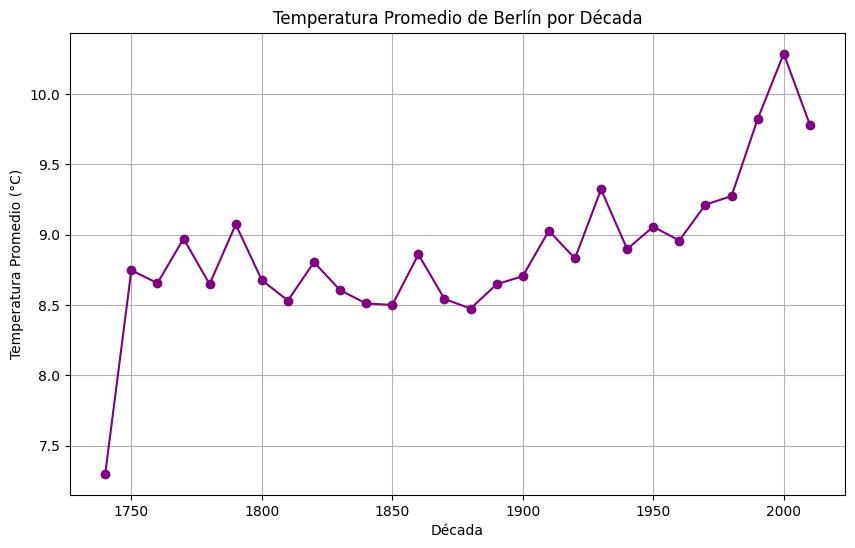

In [39]:
# Graficar la temperatura promedio por década
plt.figure(figsize=(10, 6))
plt.plot(temperatura_berlin_decada['decada'], temperatura_berlin_decada['temp_promedio'], marker='o', linestyle='-', color='purple')
plt.title('Temperatura Promedio de Berlín por Década')
plt.xlabel('Década')
plt.ylabel('Temperatura Promedio (°C)')
plt.grid(True)
plt.show()

In [33]:
import sqlite3
import pandas as pd

# Conectar a la base de datos
conn = sqlite3.connect("data_lake.bd")

# Cargar los datos en un DataFrame
df = pd.read_sql("SELECT * FROM raw_temperatures;", conn)

# Cerrar conexión
conn.close()

# Convertir la columna 'fecha' a formato datetime sin modificar los datos, usando el formato 'mixed'
df['fecha'] = pd.to_datetime(df['fecha'], errors='coerce', dayfirst=False, format='mixed')

# Extraer el año de la fecha
df['año'] = df['fecha'].dt.year

# Crear una columna para la década
df['decada'] = (df['año'] // 10) * 10

# Filtrar los registros de Bilbao
df_bilbao = df[df['ciudad'].str.contains("Bilbao", case=False, na=False)]

# Calcular la temperatura promedio por década para Bilbao
temperatura_bilbao_decada = df_bilbao.groupby('decada')['tempeProm'].mean().reset_index(name='temp_promedio')

# Mostrar el resultado
print(temperatura_bilbao_decada)


    decada  temp_promedio
0     1740      10.260923
1     1750      11.400284
2     1760      11.470525
3     1770      11.796183
4     1780      11.612342
5     1790      11.671250
6     1800      11.627167
7     1810      11.039100
8     1820      11.579517
9     1830      11.487083
10    1840      11.447192
11    1850      11.443525
12    1860      11.615150
13    1870      11.464808
14    1880      11.160083
15    1890      11.536842
16    1900      11.409683
17    1910      11.346117
18    1920      11.792708
19    1930      11.682992
20    1940      11.985983
21    1950      11.787042
22    1960      11.816025
23    1970      11.541400
24    1980      12.223658
25    1990      12.505675
26    2000      12.700783
27    2010      12.647386


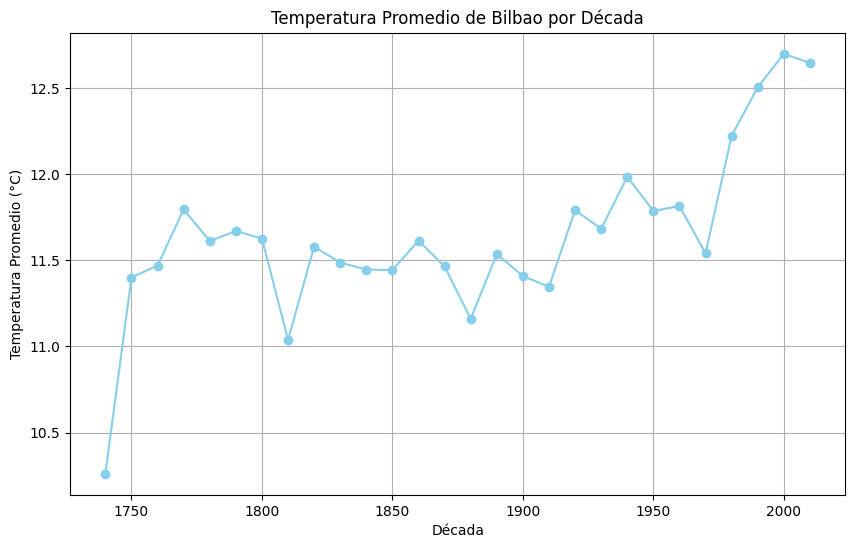

In [40]:
# Graficar la temperatura promedio por década
plt.figure(figsize=(10, 6))
plt.plot(temperatura_bilbao_decada['decada'], temperatura_bilbao_decada['temp_promedio'], marker='o', linestyle='-', color='skyblue')
plt.title('Temperatura Promedio de Bilbao por Década')
plt.xlabel('Década')
plt.ylabel('Temperatura Promedio (°C)')
plt.grid(True)
plt.show()

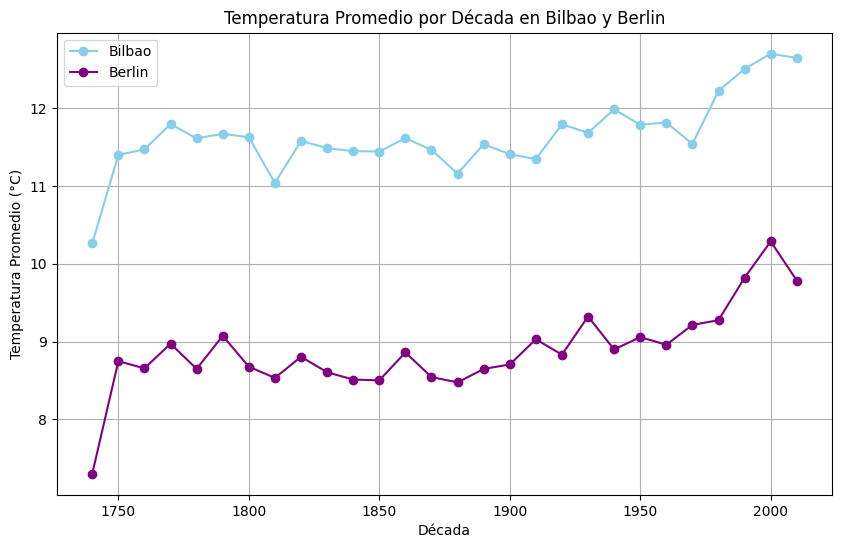

In [41]:
# Graficar la temperatura promedio por década para Bilbao y Berlín
plt.figure(figsize=(10, 6))
plt.plot(temperatura_bilbao_decada['decada'], temperatura_bilbao_decada['temp_promedio'], marker='o', linestyle='-', color='skyblue', label='Bilbao')
plt.plot(temperatura_berlin_decada['decada'], temperatura_berlin_decada['temp_promedio'], marker='o', linestyle='-', color='purple', label='Berlin')
plt.title('Temperatura Promedio por Década en Bilbao y Berlin')
plt.xlabel('Década')
plt.ylabel('Temperatura Promedio (°C)')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
# Obtener temperaturas promedio de las décadas 1750 y 2000 para Bilbao
temp_bilbao_1750 = temperatura_bilbao_decada[temperatura_bilbao_decada['decada'] == 1750]['temp_promedio'].values
temp_bilbao_2000 = temperatura_bilbao_decada[temperatura_bilbao_decada['decada'] == 2000]['temp_promedio'].values

# Obtener temperaturas promedio de las décadas 1750 y 2000 para Berlín
temp_berlin_1750 = temperatura_berlin_decada[temperatura_berlin_decada['decada'] == 1750]['temp_promedio'].values
temp_berlin_2000 = temperatura_berlin_decada[temperatura_berlin_decada['decada'] == 2000]['temp_promedio'].values

# Imprimir los resultados
print(f"Temperatura promedio en Bilbao en la década de 1750: {temp_bilbao_1750[0] if temp_bilbao_1750.size > 0 else 'No disponible'}")
print(f"Temperatura promedio en Bilbao en la década de 2000: {temp_bilbao_2000[0] if temp_bilbao_2000.size > 0 else 'No disponible'}")
print(f"Temperatura promedio en Berlín en la década de 1750: {temp_berlin_1750[0] if temp_berlin_1750.size > 0 else 'No disponible'}")
print(f"Temperatura promedio en Berlín en la década de 2000: {temp_berlin_2000[0] if temp_berlin_2000.size > 0 else 'No disponible'}")


Temperatura promedio en Bilbao en la década de 1750: 11.400284403669726
Temperatura promedio en Bilbao en la década de 2000: 12.700783333333334
Temperatura promedio en Berlín en la década de 1750: 8.748357798165138
Temperatura promedio en Berlín en la década de 2000: 10.28745
